# 2.03a - Clustering on IOB and COB only



In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering
from src.sample_filter import SampleFilter
from src.time_series_analysis import plot_night_time_series
from src.config import FIGURES_DIR, PROCESSED_DATA_DIR
from src.helper import cluster_colours

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample.get_consolidated_df()
sample.return_counts()
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))
df_variables = df[['bg mean', 'iob mean', 'iob max', 'cob mean', 'cob max']].copy().astype(float)

cluster_range = range(2,8)
night_start_hour = 17

2025-07-29 21:29:06.103 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
2025-07-29 21:29:15.706 | INFO     | src.sample_filter:__init__:68 - Number of nights objects created: 83
2025-07-29 21:29:21.869 | INFO     | src.sample_filter:return_counts:139 - For sample rate of 30 minutes:
  min_nights=30
  missed_intervals=1
2025-07-29 21:29:21.870 | INFO     | src.sample_filter:return_counts:142 - Number of candidates: 16
2025-07-29 21:29:21.870 | INFO     | src.sample_filter:return_counts:143 - Number of nights: 922


## Experiment 1: 'Efficient' Automated Feature Creartion -tsfresh

Feature Extraction:   0%|          | 0/4610 [00:00<?, ?it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df.groupby("quantiles")
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\extraction.py:354: UserWarning: linear_trend_timewise requires the data to have a index of type <class 'pandas.core.indexes.datetime

Extracted 3885 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'iob max__fft_coefficient__attr_"angle"__coeff_82', 'cob max__large_standard_deviation__r_0.45', 'iob mean__fft_coefficient__attr_"abs"__coeff_20', 'cob mean__fft_coefficient__attr_"angle"__coeff_88', 'bg mean__fft_coefficient__attr_"angle"__coeff_80', 'iob mean__fft_coefficient__attr_"real"__coeff_36', 'bg mean__fft_coefficient__attr_"imag"__coeff_59', 'iob max__fft_coefficient__attr_"angle"__coeff_72', 'iob max__large_standard_deviation__r_0.7000000000000001', 'cob max__large_standard_deviation__r_0.8500000000000001', 'cob max__count_above__t_0', 'bg mean__fft_coefficient__attr_"angle"__coeff_64', 'bg mean__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"', 'cob max__fft_coefficient__attr_"abs"__coeff_61', 'cob mean__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"min"', 'bg mean__fft_coefficient__attr_"real"__coeff_97', 'cob max__fft_coeffici

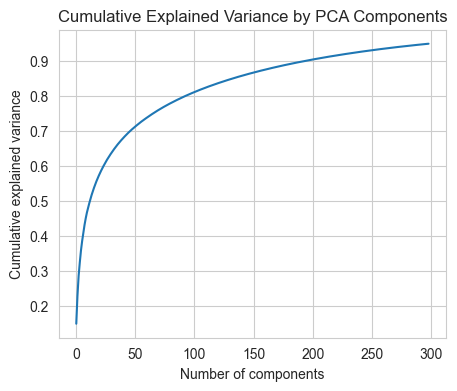

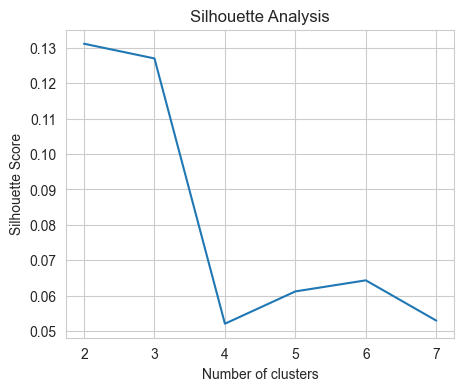

In [3]:
warnings.filterwarnings('ignore')

eff_analyser = NightClustering(df=df_variables, feature_settings='efficient', night_start_hour=night_start_hour)
night_features = eff_analyser.extract_night_level_features(multi_threaded=True)

# Preprocess Night-Level Features (Scale and PCA)
pca_features = eff_analyser.preprocess_night_features(n_components=0.95)
print("\nPreprocessed PCA features for nights:")
print(pca_features[:5])

# Plot the cumulative explained variance to help decide on the number of components
eff_analyser.plot_pca_cumulative_variance()
baseline_silhoutte_scores = eff_analyser.silhouette_analysis(cluster_range)
warnings.filterwarnings('default')

## Experiment 2: Custom Feature Creation - tsfresh

Feature Extraction:   9%|▊         | 400/4610 [00:00<00:02, 2024.42it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  18%|█▊        | 815/4610 [00:00<00:01, 2032.39it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  23%|██▎       | 1056/4610 [00:00<00:01, 2159.87it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  28%|██▊       | 1273/4610 [00:00<00:01, 2114.63it/s]C:\.env\master_project\Lib

Extracted 48 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'cob mean__minimum', 'cob max__minimum', 'iob max__count_above__t_100'}
PCA reduced dimensions from 45 to 14.


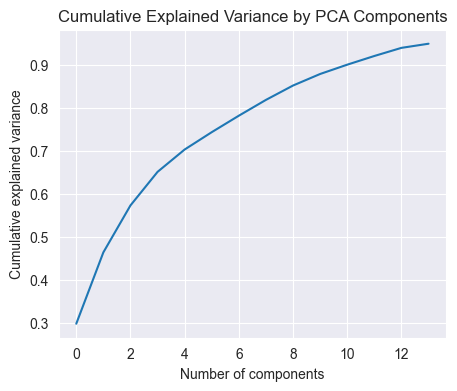

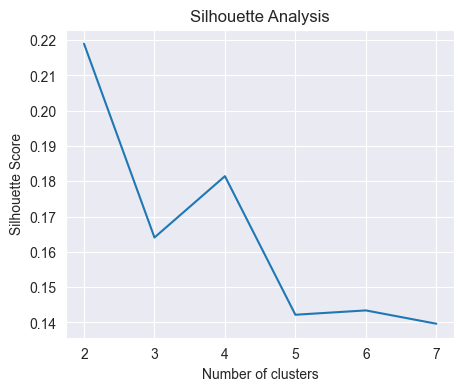

In [7]:
warnings.filterwarnings('ignore')
cust_analyser = NightClustering(df=df_variables, feature_settings='custom_no_bg', night_start_hour=night_start_hour)
night_features = cust_analyser.extract_night_level_features(multi_threaded=False)
pca_features = cust_analyser.preprocess_night_features(n_components=0.95)
cust_analyser.plot_pca_cumulative_variance()
custom_silhouette_scores = cust_analyser.silhouette_analysis(cluster_range)
warnings.filterwarnings('default')

### PCA with 14 Components and 4 Clusters

Explained variance: [0.29860965 0.16602472 0.1092206  0.07805858 0.05199139 0.0403661
 0.03832148 0.03676425 0.03342107 0.02684967 0.02166023 0.02019986
 0.01890546 0.00962938]
Night cluster distribution:
(array([0, 1, 2, 3], dtype=int32), array([124, 106, 264, 428]))


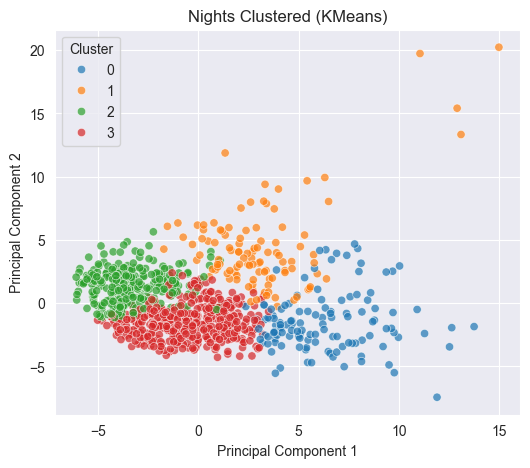

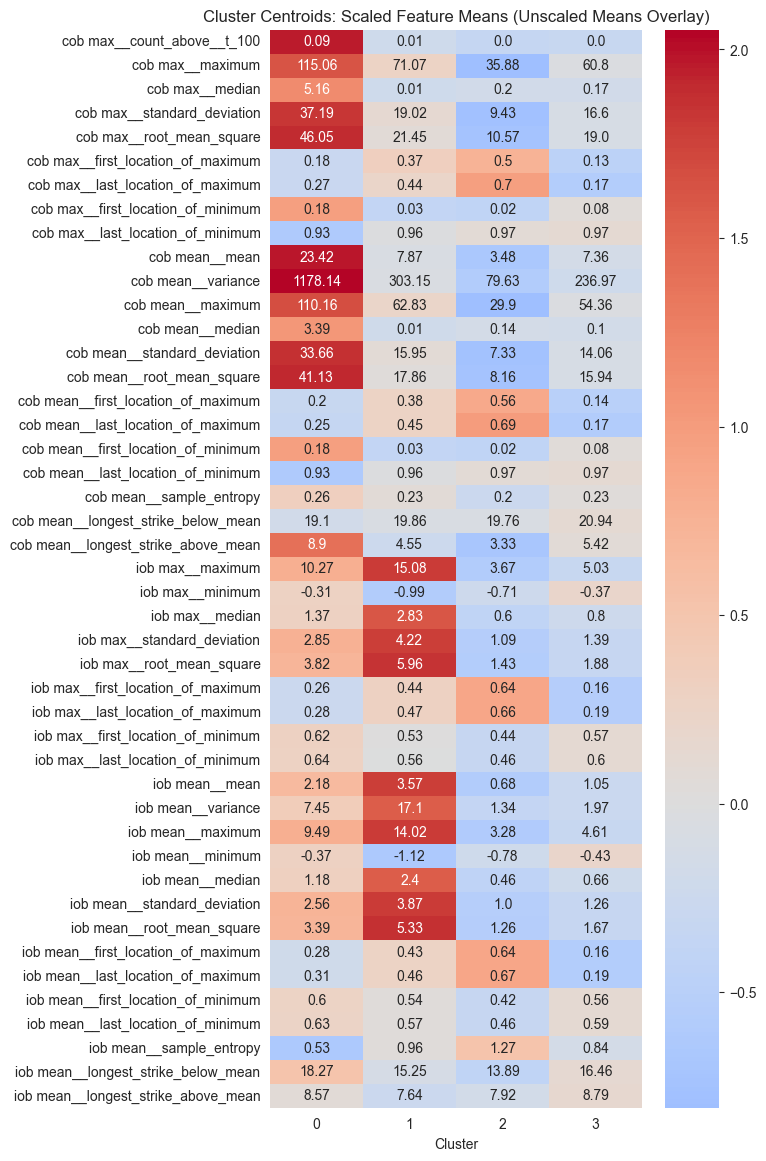

In [8]:
print(f'Explained variance: {cust_analyser.pca_model.explained_variance_ratio_}')
night_clusters = cust_analyser.cluster_nights(n_clusters=4)
cust_analyser.heatmap_cluster_features()

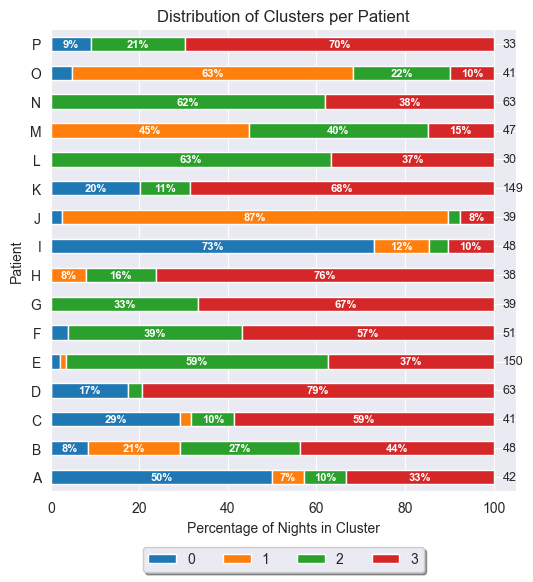

Mean entropy of cluster distribution per patient: 1.021
Normalised mean entropy of cluster distribution per patient: 0.510
Mean Gini coefficient of cluster distribution per patient: 0.514


In [9]:
cust_analyser.plot_cluster_distribution()
entropy = cust_analyser.calculate_distribution_metrics()

Plotting t-SNE with original clusters


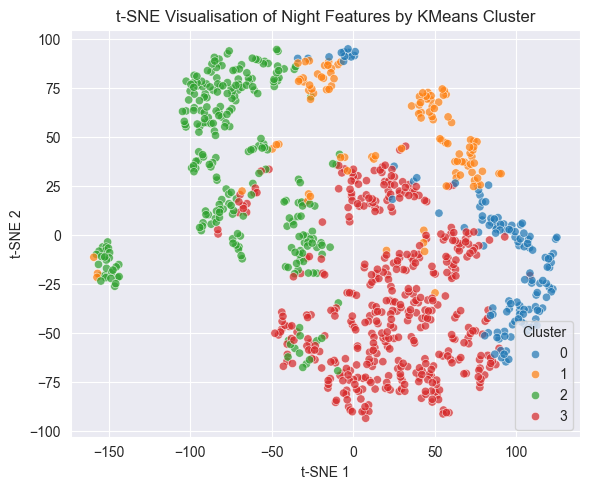

In [10]:
print('Plotting t-SNE with original clusters')
kwargs = {'perplexity': 10, 'max_iter': 80000}
cust_analyser.fit_tsne(**kwargs)
cust_analyser.plot_tsne(cluster_type='kmeans')

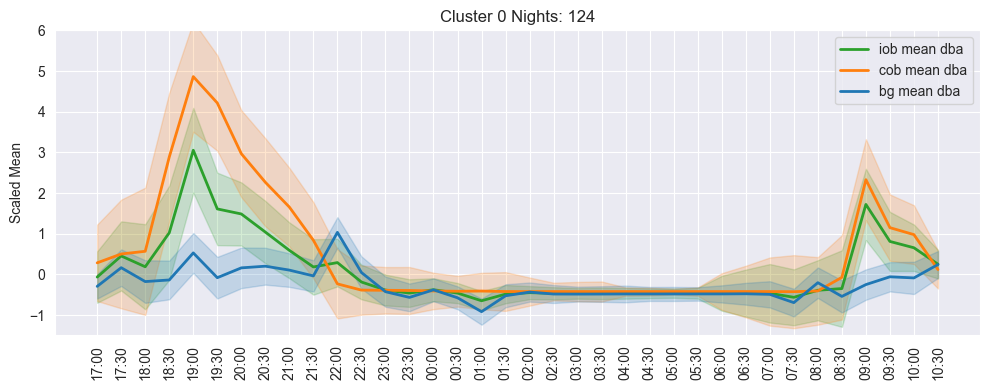

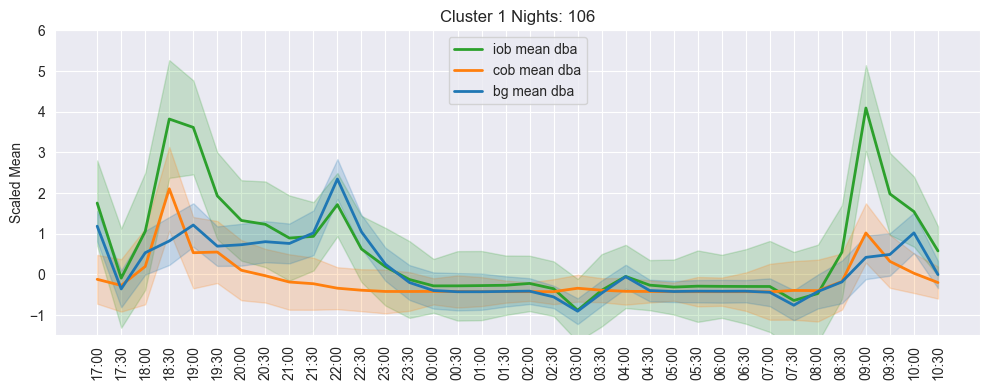

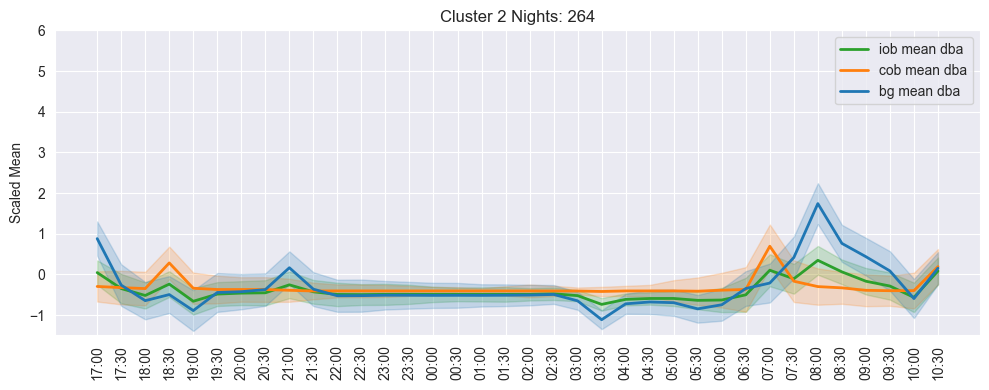

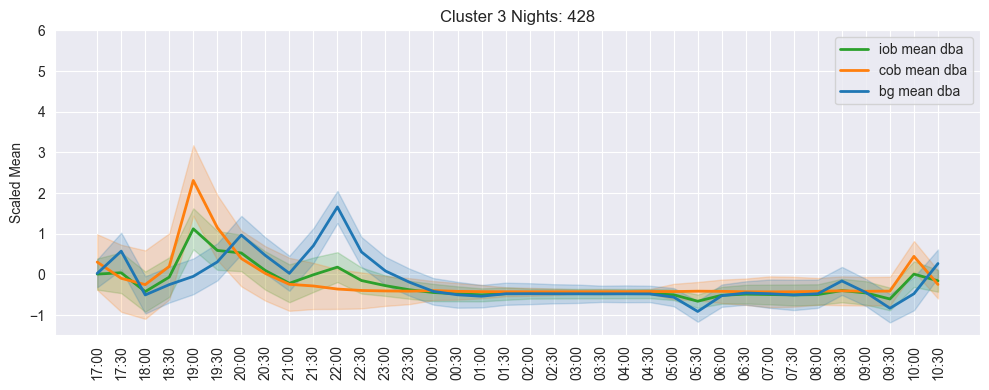

In [11]:
scaled_all_df = cust_analyser.return_dataset_with_clusters(scaled=True)
for cluster, df_cluster in scaled_all_df.groupby('cluster_label'):
    plot_night_time_series(df_cluster, night_start=night_start.hour, morning_end=morning_end.hour, method='dba', rolling_window=3, y_limits=(-1.5, 6), prescaled=True, cluster=cluster)

In [12]:
# Pickle object for later use
with open(PROCESSED_DATA_DIR / 'cust_analyser.pkl', 'wb') as file:
    pickle.dump(cust_analyser, file)


### PCA with 2 Components and 3 clusters

Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'cob mean__minimum', 'cob max__minimum', 'iob max__count_above__t_100'}
PCA reduced dimensions from 45 to 2.
Explained variance: [0.29860965 0.16602472]


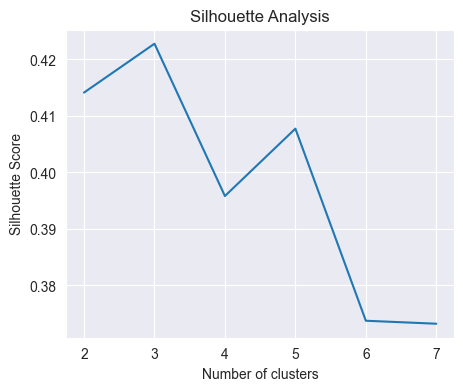

Night cluster distribution:
(array([0, 1, 2], dtype=int32), array([107, 529, 286]))


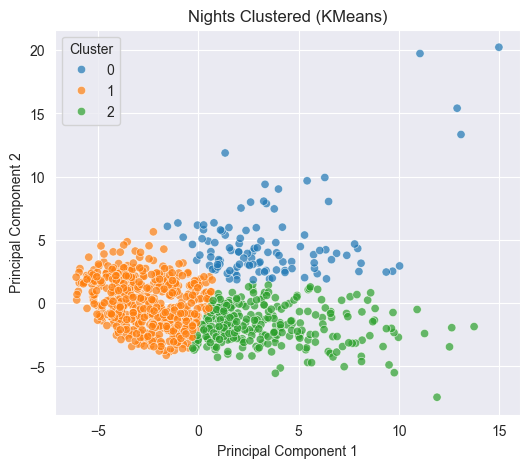

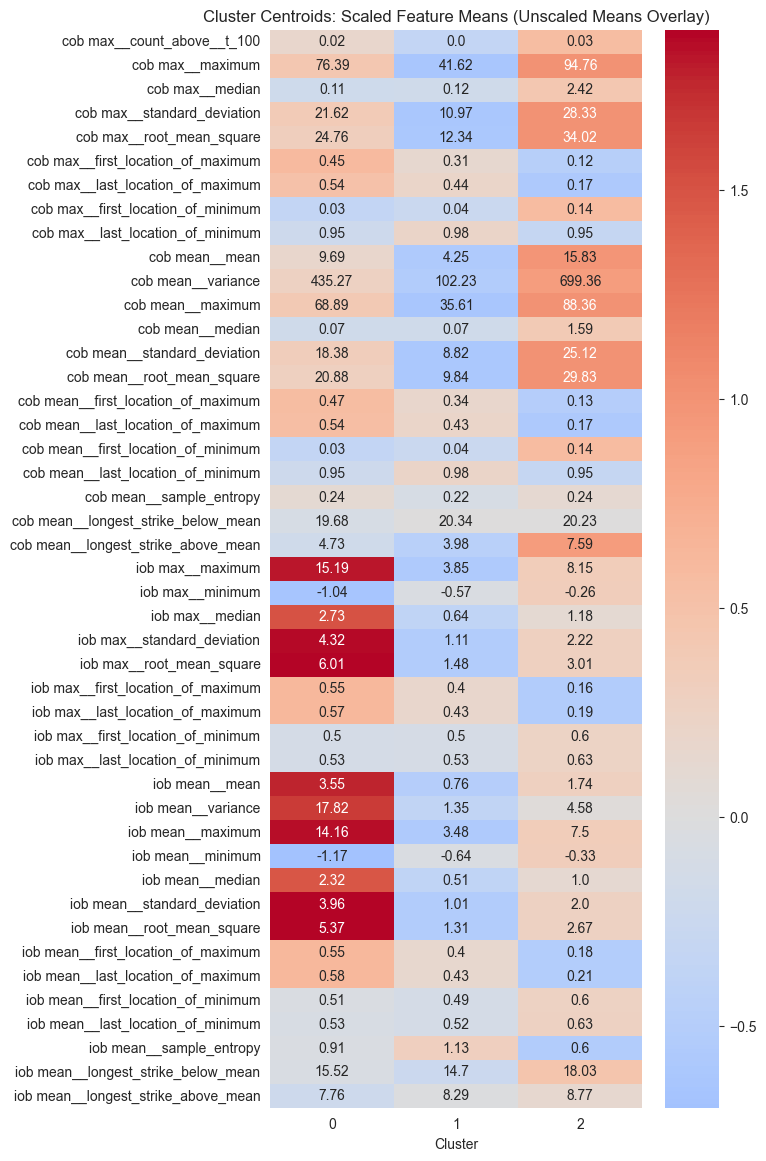

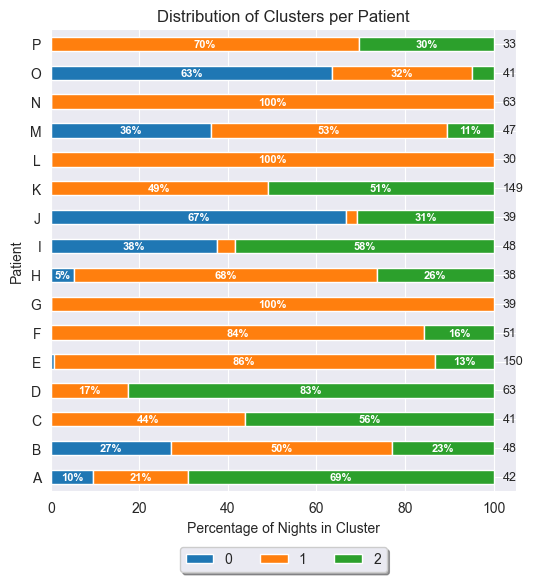

Mean entropy of cluster distribution per patient: 0.808
Normalised mean entropy of cluster distribution per patient: 0.510
Mean Gini coefficient of cluster distribution per patient: 0.458
Plotting t-SNE with original clusters


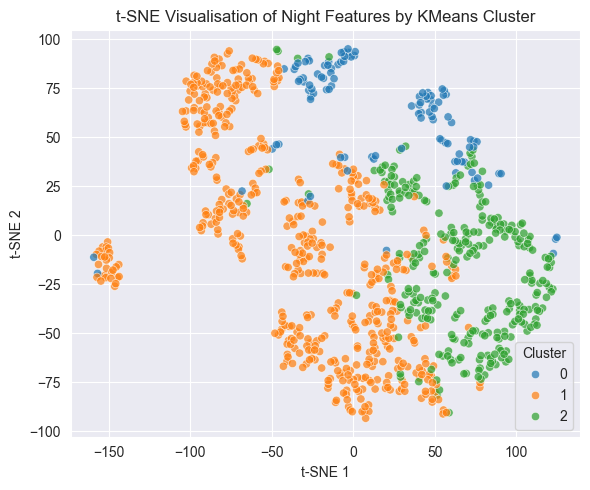

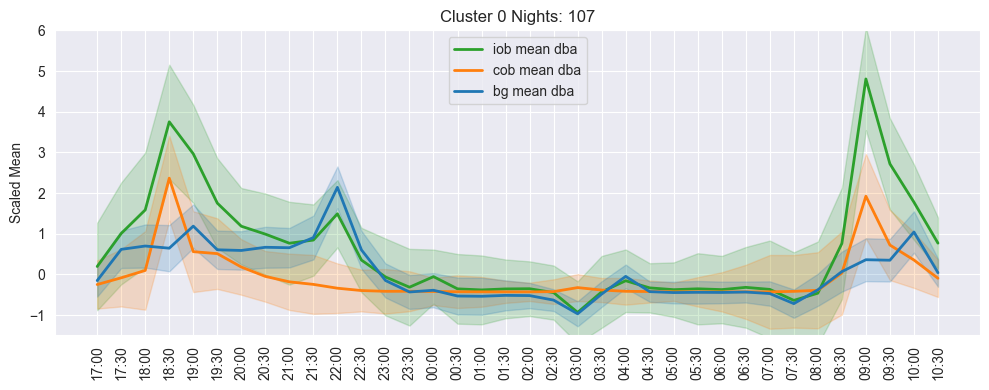

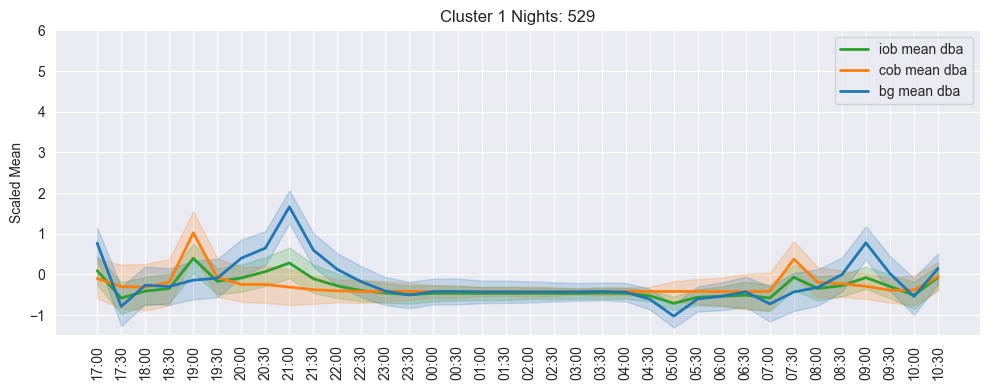

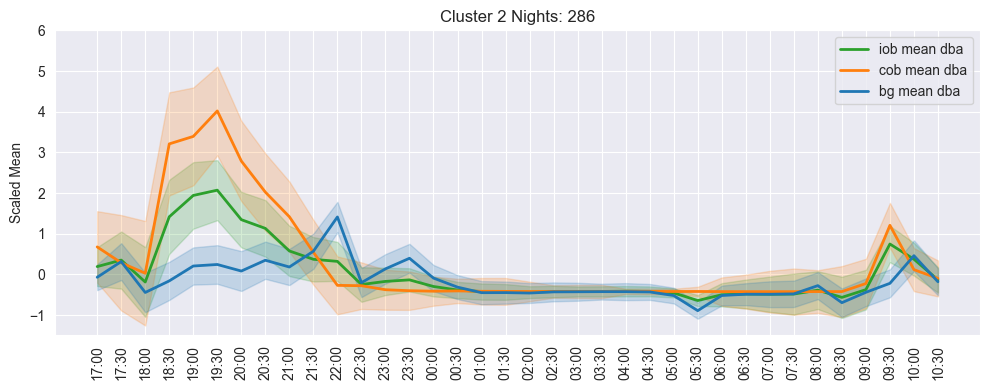

In [13]:
# Using 2 PCA components
pca_features = cust_analyser.preprocess_night_features(n_components=2)
print(
    f'Explained variance: {cust_analyser.pca_model.explained_variance_ratio_}')
pca_silhouette_scores = cust_analyser.silhouette_analysis(cluster_range)
night_clusters = cust_analyser.cluster_nights(n_clusters=3)
cust_analyser.heatmap_cluster_features()
cust_analyser.plot_cluster_distribution()
entropy = cust_analyser.calculate_distribution_metrics()
print('Plotting t-SNE with original clusters')
kwargs = {'perplexity': 10, 'max_iter': 80000}
cust_analyser.fit_tsne(**kwargs)
cust_analyser.plot_tsne(cluster_type='kmeans')
scaled_all_df = cust_analyser.return_dataset_with_clusters(scaled=True)
for cluster, df_cluster in scaled_all_df.groupby('cluster_label'):
    plot_night_time_series(df_cluster, night_start=night_start.hour, morning_end=morning_end.hour, method='dba', rolling_window=3, y_limits=(-1.5, 6), prescaled=True, cluster=cluster)

In [14]:
data = {'n_clusters': cluster_range,
        'F_baseline': baseline_silhoutte_scores,
        'F_select PCA 14': custom_silhouette_scores,
        'F_select PCA 2': pca_silhouette_scores}
silhouette_df = pd.DataFrame(data).melt(id_vars='n_clusters', var_name='clustering', value_name='score')

fig = plt.figure(figsize=(5, 4))
sns.lineplot(data=silhouette_df, x='n_clusters', y='score', hue='clustering', palette='hls')
plt.title('Comparison of silhouette scores for cluster numbers')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.legend(title=None)
plt.savefig(FIGURES_DIR / 'silhouette_analysis.png')
plt.show()

NameError: name 'baseline_silhoutte_scores' is not defined